In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('classic')
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
import pandas as pd
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.benchmarks import simulations as sims
from scipy.stats import bernoulli
import math

In [6]:
import numpy as np
np.random.seed(88889999)
import graspy
from graspy.inference import NonparametricTest
from graspy.embed import AdjacencySpectralEmbed, select_dimension

from graspy.simulations import sbm, rdpg
from graspy.utils import symmetrize, get_lcc
from graspy.plot import heatmap, pairplot
from scipy.stats import bernoulli
from mgcpy.hypothesis_tests.transforms import k_sample_transform
from tqdm import tqdm_notebook as tqdm

In [7]:
from mgcpy.independence_tests.dcorr import DCorr

In [8]:
def get(n=50):
    X1 = np.random.uniform(0.2,0.7,n).reshape(-1,1)
    # X2 = np.random.uniform(0.2,0.7,n).reshape(-1,1)
    X2 = np.random.uniform(0.4,0.9,n).reshape(-1,1)
    A1 = rdpg(X1,
          loops=False,
          rescale=False,
          directed=False)
    A2 = rdpg(X2,
          loops=False,
          rescale=False,
          directed=False)
    
    # A1 = graspy.utils.get_lcc(A1)
    # A2 = graspy.utils.get_lcc(A2)
    
    num_dims1 = select_dimension(A1)[0][-1]
    num_dims2 = select_dimension(A2)[0][-1]
    n_components = max(num_dims1, num_dims2)
    
    ase = AdjacencySpectralEmbed(n_components=1) #n_components
    A1 = ase.fit_transform(A1)
    A2 = ase.fit_transform(A2)
    return A1, A2

In [20]:
def power(indept_test, mc=100, alpha=0.05, **kwargs):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        A, B = get(**kwargs)
        X, Y = k_sample_transform(A, B)

        test_stat_alt, _ = indept_test.test_statistic(
            matrix_X=X, matrix_Y=Y, is_fast=True)
        test_stat_alt_array[i] = test_stat_alt

        # generate the null by permutation
        X2 = np.random.permutation(X)
        test_stat_null, _ = indept_test.test_statistic(
            matrix_X=X2, matrix_Y=Y, is_fast=True)
        test_stat_null_array[i] = test_stat_null

    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [10]:
%matplotlib inline

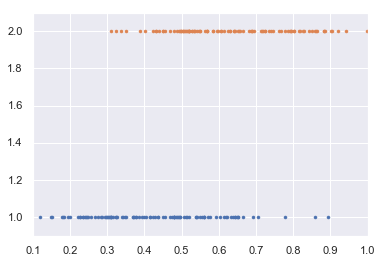

In [11]:
A, B = get(n=100)
X, Y = k_sample_transform(A, B)
plt.plot(X[:100], Y[:100],'.')
plt.plot(X[100:], Y[100:],'.')
plt.ylim([.9,2.1])
plt.show()

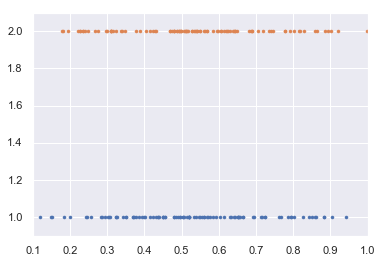

In [15]:
X2 = np.random.permutation(X)
plt.plot(X2[:100], Y[:100],'.')
plt.plot(X2[100:], Y[100:],'.')
plt.ylim([.9,2.1])
plt.show()

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
pows = []
x = range(10,101,10)
for _ in range(1):
    xs = []
    for n in tqdm(x):
        # mgc = MGC()
        dcorr = DCorr() #all 0 
        p = power(dcorr, n=n) #paired_
        xs.append(p)
    pows.append(xs)

In [23]:
pows

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

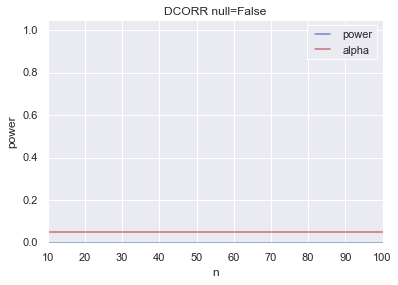

In [24]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.plot(x,pows[i], 'b', alpha=0.8 , label='power')
plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')
plt.title('DCORR null=False')
plt.savefig('power_curve_dcorr_alt.png')
plt.show()

In [18]:
x = np.random.uniform(.2,.7,100).reshape(-1,1)
y = np.random.uniform(.4,.9,100).reshape(-1,1)
A1 = rdpg(x,
          loops=False,
          rescale=False,
          directed=False)
A2 = rdpg(x,
          loops=False,
          rescale=False,
          directed=False)
A3 = rdpg(y,
          loops=False,
          rescale=False,
          directed=False)

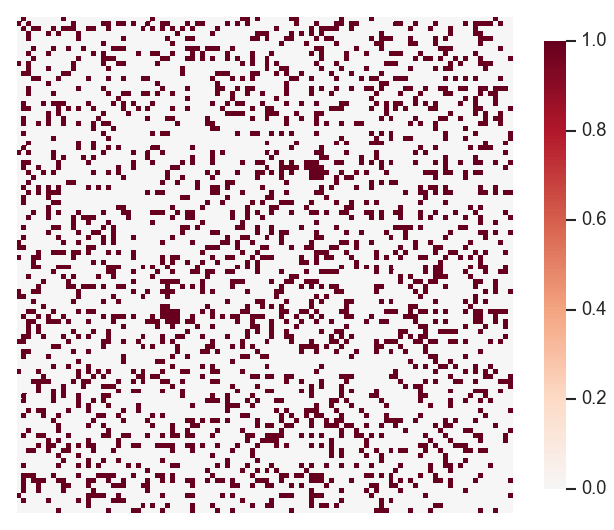

In [19]:
heatmap(A1)
plt.savefig('a1.png')
plt.show()

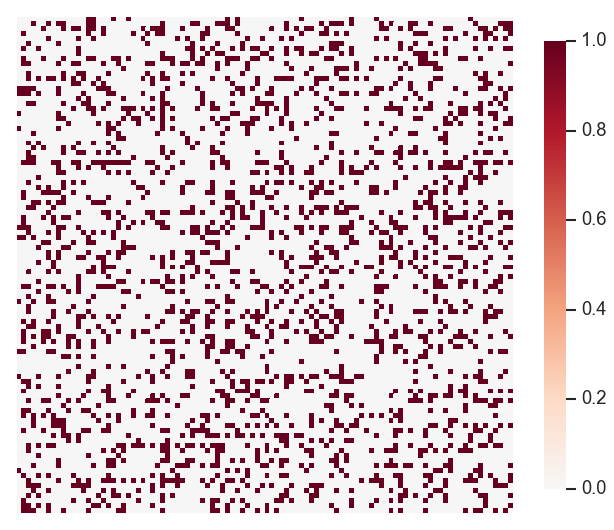

In [20]:
heatmap(A2)
plt.savefig('a2.png')
plt.show()

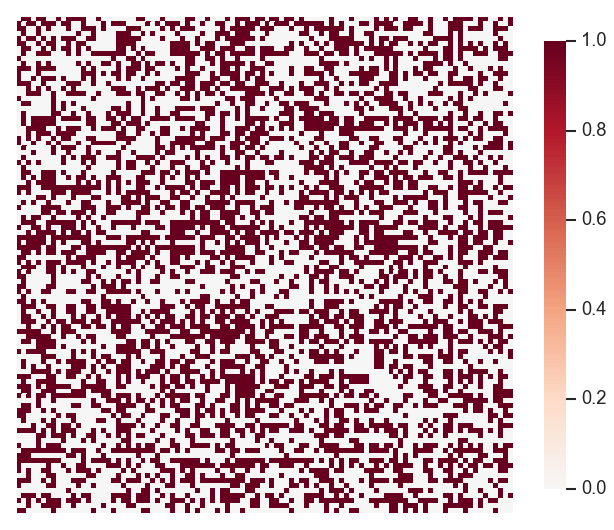

In [21]:
heatmap(A3)
plt.savefig('a3.png')
plt.show()

In [115]:
def get_graph(n, null=True):
    x = np.random.uniform(.2,.7,n).reshape(-1,1)
    y = np.random.uniform(.4,.9,n).reshape(-1,1)
    if null:
        return x, x
    else:
        return x, y
    return x,y
    
def get_power(n=50, iters=100, n_boot=200, alpha=0.05, null=True):
    x, y = get_graph(n, null=null)
    A1 = rdpg(x,
          loops=False,
          rescale=False,
          directed=False)
    A2 = rdpg(y,
          loops=False,
          rescale=False,
          directed=False)
    npt = NonparametricTest(n_bootstraps=1)
    npt.fit(A1, A2)
    sorted_ = np.sort(npt.null_distribution_)
    rej_ind = int(np.ceil(((1 - alpha)*n_boot)))
    critical_value = sorted_[rej_ind]
    rejections = 0
    for i in range(iters):
        A = rdpg(x,
          loops=False,
          rescale=False,
          directed=False)
        B = rdpg(y,
          loops=False,
          rescale=False,
          directed=False)
        npt_2 = graspy.inference.NonparametricTest(n_bootstraps=1)
        npt_2.fit(A,B)
        U = npt_2.sample_T_statistic_
        if U > critical_value:
            rejections += 1
    return rejections/iters

In [130]:
def power_npt(npt, mc=100, alpha=0.05, null=True, **kwargs):
    test_stat_null_array = np.zeros(mc)
    test_stat_alt_array = np.zeros(mc)
    for i in range(mc):
        x, y = get_graph(n, null=null)
        A1 = rdpg(x,
            loops=False,
            rescale=False,
            directed=False)
        A2 = rdpg(y,
            loops=False,
            rescale=False,
            directed=False)

        npt.fit(A1, A2)
        test_stat_alt = npt.sample_T_statistic_
        test_stat_alt_array[i] = test_stat_alt

        test_stat_null = npt.null_distribution_[0]
        test_stat_null_array[i] = test_stat_null

    critical_value = np.sort(test_stat_null_array)[math.ceil((1-alpha)*mc)]
    power = np.where(test_stat_alt_array > critical_value)[0].shape[0] / mc
    return power

In [131]:
x, y = get_graph(n, null=False)
A1 = rdpg(x,
        loops=False,
        rescale=False,
        directed=False)
A2 = rdpg(y,
        loops=False,
        rescale=False,
        directed=False)
npt = NonparametricTest(n_bootstraps=1)
npt.fit(A1, A2)
print(npt.sample_T_statistic_)
print(npt.null_distribution_)

-0.02054656172394473
[-0.02878812]


/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)


In [161]:
pows = []
x = range(10,101,10)
for _ in range(1):
    xs = []
    for n in tqdm(x):
        npt = NonparametricTest(n_bootstraps=1)
        p = power_npt(npt, n=n, null=False) #paired_
        xs.append(p)
    pows.append(xs)

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)


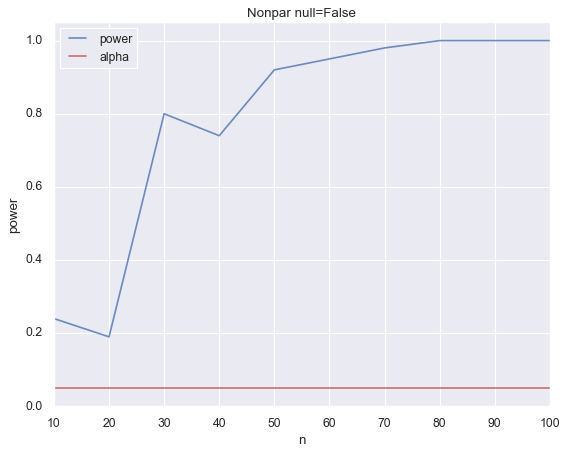

In [162]:
import matplotlib.pyplot as plt
for i in range(1):
    plt.plot(x,pows[i], 'b', alpha=0.8 , label='power')
plt.plot(x,[0.05]*len(x),'r',alpha=0.8, label='alpha')
plt.xlabel('n')
plt.ylim([0,1.05])
plt.ylabel('power')
plt.legend(loc='best')
plt.title('Nonpar null=False')
plt.savefig('power_curve_npt_alt.png')
plt.show()

In [23]:
pows = []
x = range(10,101,10)
for _ in tqdm(range(1)):
    xs = []
    for n in x:
        xs.append(get_power(n, null=True))
    pows.append(xs)

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered i

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/st

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

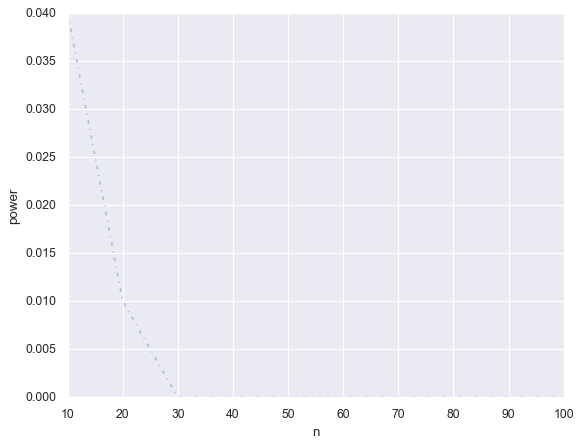

In [24]:
for i in range(1):
    plt.plot(x, pows[i], 'b-.', alpha=0.4)
#plt.plot(x,[0.05]*len(x),'r-.',alpha=0.8)
plt.xlabel('n')
plt.ylabel('power')
#plt.ylim([-0.01,0.01])
plt.savefig('power_curve_null_2.png')
plt.show()

In [25]:
pows_false = []
x = range(10,101,10)
for _ in tqdm(range(1)):
    xs = []
    for n in x:
        xs.append(get_power(n, null=False))
    pows_false.append(xs)

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1694: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/graspy/embed/ase.py:124: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspy.utils.get_lcc``.
  warnings

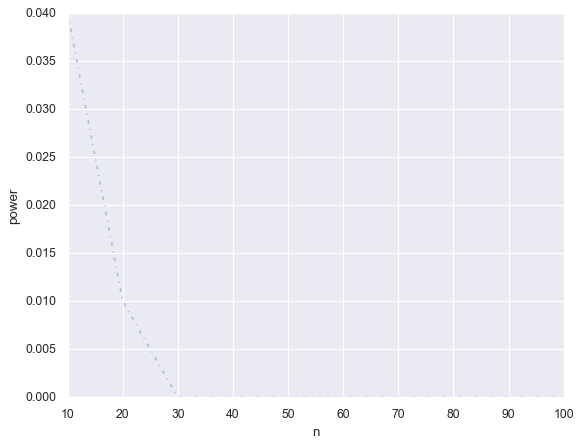

In [26]:
for i in range(1):
    plt.plot(x, pows[i], 'b-.', alpha=0.4)
#plt.plot(x,[0.05]*len(x),'r-.',alpha=0.8)
plt.xlabel('n')
plt.ylabel('power')
plt.savefig('power_curve_alt_2.png')
plt.show()